# Herramienta para la construcción de cinturones de confianza frecuentista

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.optimize as opt
import seaborn
import tqdm

tqdm.tqdm.pandas()

plt.rc("figure", dpi=100)
np.random.seed(42)


## Parámetros

In [2]:
n_samples = 10
N_exp = 10_000
N_tau = 100

taus = pd.Series(name="scale", data=np.linspace(0.01, 10, N_tau))



## Parte A

1. Generar $n$ números aleatorios $x_i$ con distribución exponencial con un valor dado de $\tau$ y calcular un estadístico $t$ igual al promedio de los $x_i$.

In [3]:
def statistic_sample(
    statistic: callable,
    distribution: st.rv_continuous,
    *,
    n_samples: int,
) -> float:
    """Calcula el dado estadístico sobre un conjunto de muestras de una dada distribución.

    Parameters
    ----------
    statistic : callable
        Función que toma un np.ndarray y devuelve un escalar.
    distribution : st.rv_continuous
        Distribución de donde se toman las muestras.
    n_samples : int
        Cantidad de muestras a tomar.

    Returns
    -------
    float
        Valor del estadistico.
    """
    samples = distribution.rvs(size=n_samples)
    return statistic(samples)


statistic_sample(statistic=np.mean, distribution=st.expon(scale=5), n_samples=n_samples)


5.134850389506605

2. Repetir el punto anterior, un numero $N_{experimentos}$ de veces y guardar el valor del estadístico $t$ obtenido cada vez en un histograma.

<AxesSubplot:ylabel='Count'>

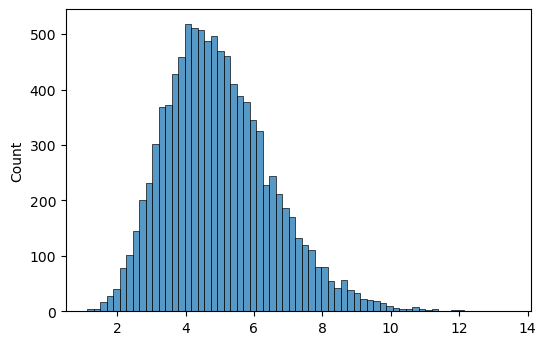

In [4]:
seaborn.histplot(
    [
        statistic_sample(np.mean, st.expon(scale=5), n_samples=n_samples)
        for _ in range(N_exp)
    ]
)


3. Para ese histograma, encontrar un valor de $t_{min}$ y $t_{max}$ tal que entre ellos se encuentre una fracción CL del total de los eventos.

En lugar de usar el histograma anterior, tomo directamente los percentiles 16 y 84 de un conjunto de $N_{experimentos}$, para obtener el intervalo correspondiente al 68% de las muestras.

In [5]:
def statistic_quantiles_montecarlo(
    statistic: callable,
    distribution: st.rv_continuous,
    *,
    n_samples: int,
    n_experiments: int,
    quantiles=(0.16, 0.84),
) -> pd.Series:
    """Calcula los cuantiles de un dado estadistico a través de una simulación
    Monte Carlo.

    Parameters
    ----------
    statistic : callable
        Función que toma un np.ndarray y devuelve un escalar.
    distribution : st.rv_continuous
        Distribución de donde se toman las muestras.
    n_samples : int
        Cantidad de muestras a tomar.
    n_experiments : int
        Número de experimentos de Monte Carlo a realizar.
    quantiles : array-like, optional
        Cuantiles a calcular, por defecto (0.16, 0.84)

    Returns
    -------
    pd.Series
    """

    samples = np.empty(n_experiments)
    for i in range(n_experiments):
        samples[i] = statistic_sample(statistic, distribution, n_samples=n_samples)
    statistic_quantiles = np.quantile(samples, quantiles)
    return pd.Series(data=statistic_quantiles, index=quantiles)


statistic_quantiles_montecarlo(
    statistic=np.mean,
    distribution=st.expon(scale=5),
    n_samples=n_samples,
    n_experiments=N_exp,
)


0.16    3.455224
0.84    6.560823
dtype: float64

4. Repetir los tres puntos anteriores para 100 valores de $\tau$ entre $0$ y $10$ y graficar el cinturón de confianza en el plano $\tau$ vs $t$.

In [6]:
def confidence_belt(
    statistic: callable,
    distribution: st.rv_continuous,
    parameter: pd.Series,
    *,
    n_samples: int,
    n_experiments: int,
    quantiles=(0.16, 0.84),
) -> pd.DataFrame:
    """Calcula el cinturon de confianza para un dado estadístico.

    Parameters
    ----------
    statistic : callable
        Función que toma un np.ndarray y devuelve un escalar.
    distribution : st.rv_continuous
        Distribución de donde se toman las muestras.
    parameter : pd.Series
        Parámetros para los que evaluar la distribución. El nombre
        de la serie de Pandas debe ser el nombre del parámetro en
        la función `distribution`.
    n_samples : int
        Cantidad de muestras a tomar.
    n_experiments : int
        Número de experimentos de Monte Carlo a realizar.
    quantiles : array-like, optional
        Cuantiles a calcular, por defecto (0.16, 0.84)

    Returns
    -------
    pd.DataFrame
    """
    return parameter.progress_apply(
        lambda p: statistic_quantiles_montecarlo(
            statistic,
            distribution(**{parameter.name: p}),
            n_samples=n_samples,
            n_experiments=n_experiments,
            quantiles=quantiles,
        )
    ).set_index(parameter)


belt_expon_mean = confidence_belt(
    statistic=np.mean,
    distribution=st.expon,
    parameter=taus,
    n_samples=n_samples,
    n_experiments=N_exp,
    quantiles=(0.16, 0.5, 0.84),
)

belt_expon_mean.head()


100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


,0.16,0.50,0.84
scale,,,
0.010000,0.006925,0.009691,0.013092
0.110909,0.076661,0.106344,0.144201
0.211818,0.146549,0.205523,0.276906
0.312727,0.215843,0.301468,0.409951
0.413636,0.285899,0.401511,0.542415


Text(0, 0.5, 'Estadístico promedio')

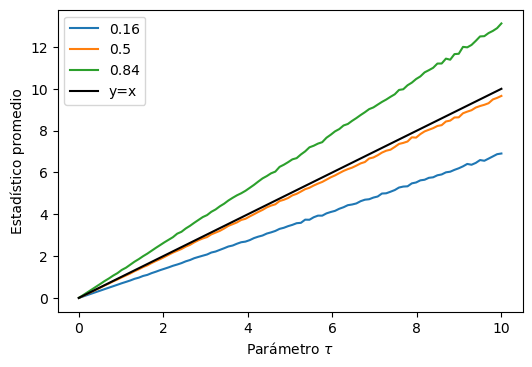

In [7]:
belt_expon_mean.plot()
plt.plot([0, 10], [0, 10], color="k", label="y=x")
plt.legend()
plt.xlabel(r"Parámetro $\tau$")
plt.ylabel("Estadístico promedio")


El cinturón de confianza está (aproximadamente) centrado en la recta identidad, que es el valor ideal para un estimador del parámetro. Como el promedio es el estimador de máxima verosimilitud para el parámetro $\tau$ de la exponencial, su esperanza debería coincidir con la recta $y=x$. No necesariamente su mediana, ya que la distribución puede no ser simétrica. Se ve que esta (en naranja) va ligeramente por debajo de la recta negra.

## Parte B

Utilizar la herramienta generada en la Parte A para otros dos estadísticos:

1. la mediana 

100%|██████████| 100/100 [04:26<00:00,  2.67s/it]


Text(0, 0.5, 'Estadístico mediana')

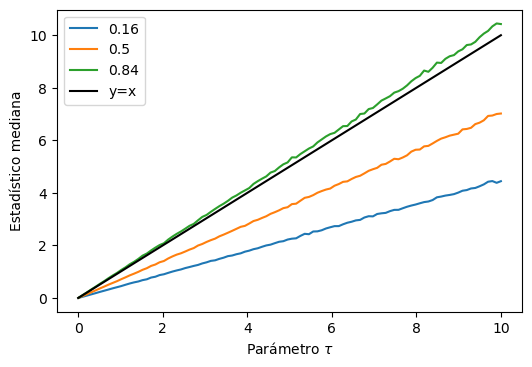

In [8]:
belt_expon_median = confidence_belt(
    statistic=np.median,
    distribution=st.expon,
    parameter=taus,
    n_samples=n_samples,
    n_experiments=N_exp,
    quantiles=(0.16, 0.5, 0.84),
)

belt_expon_median.plot()
plt.plot([0, 10], [0, 10], color="k", label="y=x")
plt.legend()
plt.xlabel(r"Parámetro $\tau$")
plt.ylabel("Estadístico mediana")


2. $t = \sum_i (x_i + x_i^2 + x_i^3 + x_i^4)$

100%|██████████| 100/100 [04:19<00:00,  2.60s/it]


Text(0, 0.5, 'Estadístico $\\sum_i (x_i + x_i^2 + x_i^3 + x_i^4)$')

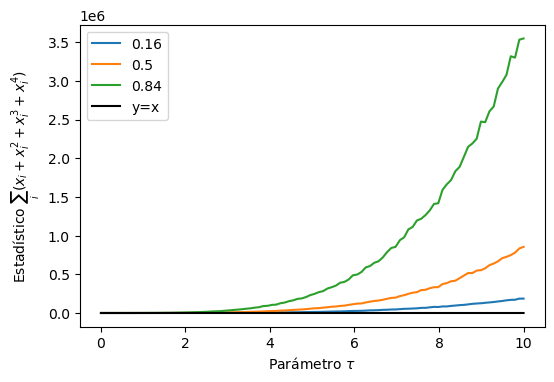

In [9]:
def powersum_statistic(x):
    return sum(np.sum(x ** i) for i in range(1, 5))


belt_expon_powersum = confidence_belt(
    statistic=powersum_statistic,
    distribution=st.expon,
    parameter=taus,
    n_samples=n_samples,
    n_experiments=N_exp,
    quantiles=(0.16, 0.5, 0.84),
)

belt_expon_powersum.plot()
plt.plot([0, 10], [0, 10], color="k", label="y=x")
plt.legend()
plt.xlabel(r"Parámetro $\tau$")
plt.ylabel(r"Estadístico $\sum_i (x_i + x_i^2 + x_i^3 + x_i^4)$")


## Parte C
Discutir que pasa si como "estadístico" $t$ utilizamos el $q$ de Wilks visto en clase. 

El $q$ de Wilks está definido como:

$$ q = -2 \ln \frac{ \mathcal{L}(y \,|\, \theta) }{ \mathcal{L}(y \,|\, \hat{\theta}) } $$

donde $\mathcal{L}(y \,|\, \theta)$ es la verosímilitud, y $\hat{\theta}$ es el estimador de máxima verosimilitud.

Hay dos problemas al querer calcular un cinturon de confianza a partir de esta magnitud:

1. El $q$ de Wilks no es un estadístico, ya que un estadístico solo puede ser función de los datos $y$. En cambio, $q$ depende explícitamente del parámetro $\theta$.

2. Mientras que está magnitud depende explícitamente del parámetro, su distribución no depende (en el límite asintótico) de este parámetro.

Por lo tanto, esta magnitud no nos sirve para calcular un cinturon de confianza.

En el límite asintótico, esta magnitud tiene una distribución $\chi^2$ de $k$ grados de libertad, donde $k$ depende de la diferencia de dimensionalidad entre $\theta$ y $\hat{\theta}$. En el caso de la distribución exponencial, donde $\theta = \tau$ y $\theta_0 = \frac{1}{N} \sum_i x_i$, tenemos que $q$ es aproximadamente una $\chi^2_1$.

Sin embargo, podemos probar hacer el cinturón utilizando el parámetro real. Como el estadístico de Wilks depende explícitamente del parámetro, no se puede reusar directamente las funciones anteriores.

Para hacer más rápida la simulación, vamos a aprovechar que, en el caso de la exponencial, el estimador de máxima verosimilitud es el promedio.

100%|██████████| 100/100 [03:25<00:00,  2.06s/it]


Text(0, 0.5, 'Estadístico $q$')

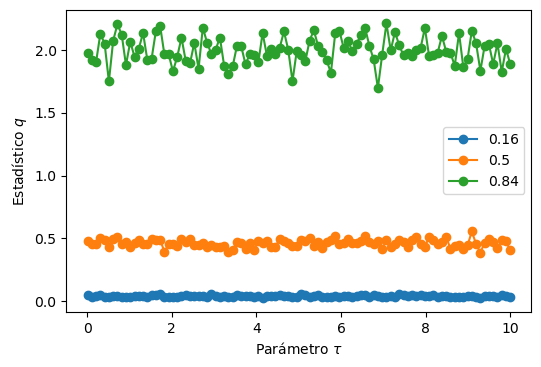

In [10]:
def confidence_belt_wilks(
    distribution: st.rv_continuous,
    maximum_likelihood_estimator: callable,
    parameter: pd.Series,
    *,
    n_samples: int,
    n_experiments: int,
    quantiles=(0.16, 0.5, 0.84),
):
    """Cinturon de confianza para el estadístico de Wilks.

    Parameters
    ----------
    distribution : st.rv_continuous
        Distribución de donde se toman las muestras.
    maximum_likelihood_estimator : callable
        Estimador de máxima verosimilitud. Toma un np.ndarray y devuelve un escalar.
    parameter : pd.Series
        Parámetros para los que evaluar la distribución. El nombre
        de la serie de Pandas debe ser el nombre del parámetro en
        la función `distribution`.
    n_samples : int
        Cantidad de muestras a tomar.
    n_experiments : int
        Número de experimentos de Monte Carlo a realizar.
    quantiles : array-like, optional
        Cuantiles a calcular, por defecto (0.16, 0.84)

    Returns
    -------
    pd.DataFrame
    """
    # La función definida antes toma un estadístico que no depende del parámetro,
    # Para reusar el código, definimos una fución que toma el parámetro y devuelve
    # otra función que no depende del parámetro.
    def likelihood_ratio_statistic(p):
        dist_fixed = distribution(**{parameter.name: p})

        def statistic(x):
            p_hat = maximum_likelihood_estimator(x)
            dist_max = distribution(**{parameter.name: p_hat})
            return -2 * (dist_fixed.logpdf(x).sum() - dist_max.logpdf(x).sum())

        return statistic

    return parameter.progress_apply(
        lambda p: statistic_quantiles_montecarlo(
            distribution=distribution(**{parameter.name: p}),
            statistic=likelihood_ratio_statistic(p),
            n_samples=n_samples,
            n_experiments=n_experiments,
            quantiles=quantiles,
        )
    ).set_index(parameter)


belt_wilks = confidence_belt_wilks(
    distribution=st.expon,
    maximum_likelihood_estimator=np.mean,
    parameter=taus,
    n_samples=n_samples,
    n_experiments=N_exp // 10,
    quantiles=(0.16, 0.5, 0.84),
)

belt_wilks.plot(marker="o")
plt.xlabel(r"Parámetro $\tau$")
plt.ylabel("Estadístico $q$")


Los intervalos para esta magnitud son independientes del parámetro, por lo que para un dado estadístico, el intervalo sería $[0, \infty)$.

## Parte D
Utilizar Wilks para calcular el intervalo de confianza para el parámetro $\tau$ de la exponencial con un dado CL.

In [11]:
def likelihood_interval(samples):
    dist = st.expon
    p_hat = np.mean(samples)
    LL_max = dist.logpdf(samples, scale=p_hat).sum()

    def likelihood_ratio(p, delta=1):
        return -2 * (dist.logpdf(samples, scale=p).sum() - LL_max) - delta

    sigma = np.std(samples) / samples.size ** 0.5
    
    for n in range(10):
        x1 = p_hat - n * sigma
        if likelihood_ratio(x1) > 0:
            break
    lower_lim = opt.root_scalar(likelihood_ratio, x0=p_hat, x1=x1).root
    
    for n in range(10):
        x1 = p_hat + n * sigma
        if likelihood_ratio(x1) > 0:
            break
    upper_lim = opt.root_scalar(likelihood_ratio, x0=p_hat, x1=x1).root
    return lower_lim, upper_lim


samples = st.expon(scale=5).rvs(n_samples)
likelihood_interval(samples)


(3.0253732605485437, 5.704459723754475)

## Parte E
(Opcional) Calcular la cobertura de los intervalos calculados en los ítems anteriores en función del parámetro $\tau$ 

Para calcular el intervalo de confianza para un dado valor del estadístico, realizamos una interpolación lineal para cada una de las curvas del cinturón de confianza calculado anteriormente. Por ejemplo, para un valor $t=5$ en el caso del promedio:

In [12]:
def confidence_interval(statistic: float, confidence_belt: pd.DataFrame) -> pd.Series:
    """Calcula el intervalo de confianza interpolando linealmente el cinturón
    de confianza.

    Parameters
    ----------
    statistic : float
        Valor del estadístico.
    confidence_belt : pd.DataFrame
        Cinturón de confianza.

    Returns
    -------
    pd.Series
    """
    return confidence_belt.apply(lambda x: np.interp(statistic, x, x.index))


confidence_interval(5, belt_expon_mean)


0.16    7.231726
0.50    5.175730
0.84    3.838600
dtype: float64

donde un intervalo de confianza de $68\%$ corresponde a $[3.80, 7.28]$.

Para calcular la cobertura para un dado valor del parámetro $\tau$, generamos muestras, calculamos el estadístico y calculamos la fracción de veces que el intervalo de confianza contiene al parámetro.

In [13]:
def coverage(
    statistic: callable,
    distribution: st.rv_continuous,
    parameter: float,
    *,
    belt: pd.DataFrame,
    n_samples: int,
    n_experiments: int,
) -> float:
    """Calcula la cobertura del cinturón de confianza para un dado parámetro
    a partir de experimentos de Monte Carlo.

    Parameters
    ----------
    statistic : callable
        Función que toma un np.ndarray y devuelve un escalar.
    distribution : st.rv_continuous
        Distribución de donde se toman las muestras.
    belt : pd.DataFrame
        Cinturón de confianza.
    n_samples : int
        Cantidad de muestras a tomar.
    n_experiments : int
        Número de experimentos de Monte Carlo a realizar.

    Returns
    -------
    float
    """
    coverage = 0
    for _ in range(n_experiments):
        samples = distribution.rvs(n_samples)
        ci = confidence_interval(statistic(samples), belt)
        if ci.min() <= parameter <= ci.max():
            coverage += 1

    return coverage / n_experiments


coverage(
    np.mean,
    st.expon(scale=5),
    parameter=5,
    belt=belt_expon_mean,
    n_samples=n_samples,
    n_experiments=N_exp,
)


0.6841

In [14]:
def coverage_likelihood(
    distribution: st.rv_continuous,
    parameter: float,
    *,
    n_samples: int,
    n_experiments: int,
) -> float:
    """Calcula la cobertura del intervalo confianza de Wilks
    para un dado parámetro a partir de experimentos de Monte Carlo.

    Parameters
    ----------
    distribution : st.rv_continuous
        Distribución de donde se toman las muestras.
    n_samples : int
        Cantidad de muestras a tomar.
    n_experiments : int
        Número de experimentos de Monte Carlo a realizar.

    Returns
    -------
    float
    """
    coverage = 0
    for _ in range(n_experiments):
        samples = distribution.rvs(n_samples)
        p_min, p_max = likelihood_interval(samples)
        if p_min <= parameter <= p_max:
            coverage += 1

    return coverage / n_experiments


coverage_likelihood(
    st.expon(scale=5),
    parameter=5,
    n_samples=n_samples,
    n_experiments=N_exp,
)


0.6748

Podemos repetir esto para distintos valores del parámetro y obtener la cobertura en función del parámetro:

In [15]:
def belt_coverage(
    parameters: pd.Series,
    *,
    statistic: callable,
    distribution: st.rv_continuous,
    belt: pd.DataFrame,
    n_samples: int,
    n_experiments: int,
) -> pd.Series:
    """Cobertura del cinturon de confianza en función del parámetro.

    Parameters
    ----------
    parameter : pd.Series
        Parámetros para los que evaluar la distribución. El nombre
        de la serie de Pandas debe ser el nombre del parámetro en
        la función `distribution`.
    statistic : callable
        Función que toma un np.ndarray y devuelve un escalar.
    distribution : st.rv_continuous
        Distribución de donde se toman las muestras.
    belt : pd.DataFrame
        Cinturón de confianza.
    n_samples : int
        Cantidad de muestras a tomar.
    n_experiments : int
        Número de experimentos de Monte Carlo a realizar.

    Returns
    -------
    pd.Series
    """
    parameter_coverages = parameters.progress_apply(
        lambda p: coverage(
            statistic=statistic,
            distribution=distribution(**{parameters.name: p}),
            parameter=p,
            belt=belt,
            n_samples=n_samples,
            n_experiments=n_experiments,
        )
    )
    return pd.Series(data=parameter_coverages.values, index=parameters)


In [16]:
coverages = {}
for statistic, belt, n_samples in [
    (np.mean, belt_expon_mean, 10),
    (np.median, belt_expon_median, 10),
    (powersum_statistic, belt_expon_powersum, 10),
]:
    coverages[statistic.__name__] = belt_coverage(
        taus,
        statistic=statistic,
        distribution=st.expon,
        belt=belt,
        n_samples=n_samples,
        n_experiments=N_exp // 10,
    )

coverages = pd.DataFrame(coverages)


100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


In [17]:
coverages["likelihood"] = pd.Series(data=taus.progress_apply(
    lambda p: coverage_likelihood(
        st.expon(scale=p),
        parameter=p,
        n_samples=n_samples,
        n_experiments=N_exp // 10,
    )
).values, index=taus)


100%|██████████| 100/100 [13:08<00:00,  7.89s/it]


Text(0, 0.5, 'Cobertura')

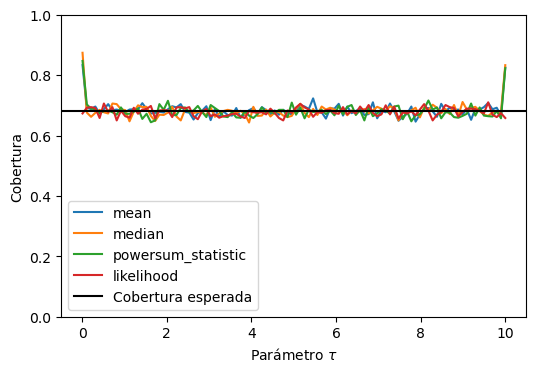

In [18]:
coverages.plot()
plt.axhline(0.68, color="k", label="Cobertura esperada")
plt.legend()
plt.ylim(0, 1)
plt.xlabel(r"Parámetro $\tau$")
plt.ylabel("Cobertura")


## Parte F

(Inventado) Comparar los anchos de los intervalos obtenidos para cada estimador.

Para un conjunto de $n$ muestras, calculo el ancho del intervalo correspondiente a los percentiles 16 y 84 para los tres estadísticos considerados anteriormente.

In [19]:
def confidence_interval_width(statistic, belt):
    ci = confidence_interval(statistic, belt)
    return ci[0.16] - ci[0.84]


def confidence_interval_widths():
    samples = np.random.exponential(scale=5, size=n_samples)
    return {
        statistic.__name__: confidence_interval_width(statistic(samples), belt)
        for statistic, belt in [
            (np.mean, belt_expon_mean),
            (np.median, belt_expon_median),
            (powersum_statistic, belt_expon_powersum),
        ]
    }


pd.Series(confidence_interval_widths())


mean                  3.172228
median                3.560124
powersum_statistic    4.955905
dtype: float64

Repetimos esto múltiples veces:

In [20]:
df = pd.DataFrame([confidence_interval_widths() for _ in tqdm.trange(N_exp)])

df.head()


100%|██████████| 10000/10000 [00:32<00:00, 304.27it/s]


,mean,median,powersum_statistic
0,2.939146,5.371813,2.612954
1,3.993731,3.850958,4.538384
2,2.886880,4.635515,3.023318
3,4.629504,4.626316,5.058121
4,3.686216,3.551661,5.218128


y comparamos las distribuciones de anchos:

Text(0.5, 0, 'Ancho del intervalo')

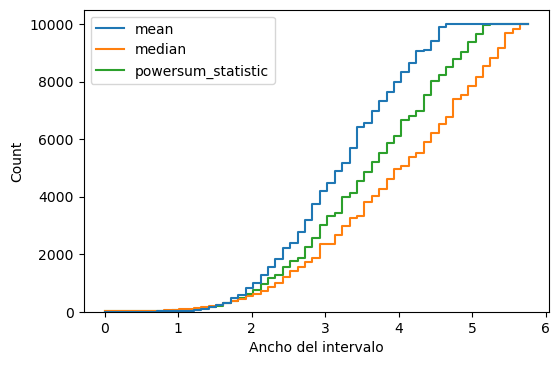

In [21]:
seaborn.histplot(df, cumulative=True, fill=False, element="step")
plt.xlabel("Ancho del intervalo")


Los anchos obtenidos por el promedio son menores a los anchos dados por los otros dos estadísticos. Llamativamente, el de la mediana es peor que el de la suma de potencias.

Pero no siempre es más chico el intervalo correspondiente al promedio.

In [22]:
df.corr(lambda x, y: (x < y).mean())


,mean,median,powersum_statistic
mean,1.0000,0.7861,0.7421
median,0.7861,1.0000,0.3676
powersum_statistic,0.7421,0.3676,1.0000


Por ejemplo, solo el 79% de las veces, los intervalos del promedio son menores al de la mediana, y 73% al de la suma de potencias.